### Model Parameters: `p` and `t`

- **`p` (number of variables)**  
  `p` is the dimension of the multivariate time series we are modeling.  
  - Example: if `p = 128`, then at each time step \( y_t \) is a 128‑dimensional vector.  
  - In our graph interpretation, these are the **nodes**.  
  - `p` determines:
    - Size of the coefficient matrix \( c \) (`d*p` × `p`)
    - Shape of the latent tree weight matrices \( W \) (`p` × `p` × `m`)
    - Number of possible undirected edges: \( \frac{p(p-1)}{2} \)

- **`t` (temperature scaling parameter)**  
  `t` is a hyperparameter controlling how sharply latent tree weights in \( W \) are converted into adjacency values in \( Z \).  
  - We scale \( W \) by `1/t`
  - Smaller `t` → **sharper** thresholding (weights near 0 go to 0 quickly, large weights stay large)  
  - Larger `t` → **smoother** transition (weights spread over a range)  
  - This controls how confident we are about edges in the projected trees.


In [1]:
import networkx as nx
import numpy as np
import torch
from torch.autograd.functional import jacobian
import pylab as plt
torch.set_default_tensor_type(torch.DoubleTensor)

/usr/local/lib/python3.11/dist-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [2]:
p = 128

t = 1

In [3]:
def log_partition(W):

    W_ltri = torch.tril(W,diagonal=-1)

    W_sym = W_ltri+ W_ltri.T

    W_sym =  W_sym

    A = torch.exp(W_sym)

    L = torch.diag_embed(A.sum(1)) - A +  torch.eye(p)*1E-14

    return torch.slogdet(L[1:,1:])[1]


def GetA(W):
    """
    Compute adjacency matrix from given parameters.
    Parameters:
        <args>: description of arguments.
    Returns:
        torch.Tensor: adjacency matrix.
    """


    Mltri = jacobian(log_partition,W)*t

    A = Mltri+Mltri.T

    A.fill_diagonal_(fill_value = 1, wrap = False)

    return A

In [4]:
W = torch.rand([p,p])

W = torch.log(W)

A_tree = GetA( W*1000 + np.log(1000))


A_tree.sum()

A_tree = A_tree.numpy()

A_tree_threshold = 1.0* (A_tree>5E-1)

G = nx.from_numpy_array(A_tree_threshold)

A_tree_threshold.sum()


np.float64(378.0)

In [5]:
tau = 1.0/500

In [6]:
W_ltri = torch.tril(W/tau,diagonal=-1)

W_sym = W_ltri+ W_ltri.T

W_sym =  W_sym - W_sym.max()

A = torch.exp(W_sym)

D = A.sum(1)

L = torch.diag_embed(D) - A

L_inv = torch.inverse(L + 1/p**2 + torch.eye(p)*1E-14)
L_inv_diag = torch.diag(L_inv)
prob = -((2*L_inv - L_inv_diag).T - L_inv_diag) * A

In [7]:
Aprob=(prob>0.54)*1

In [8]:
Aprob.sum()

tensor(246)

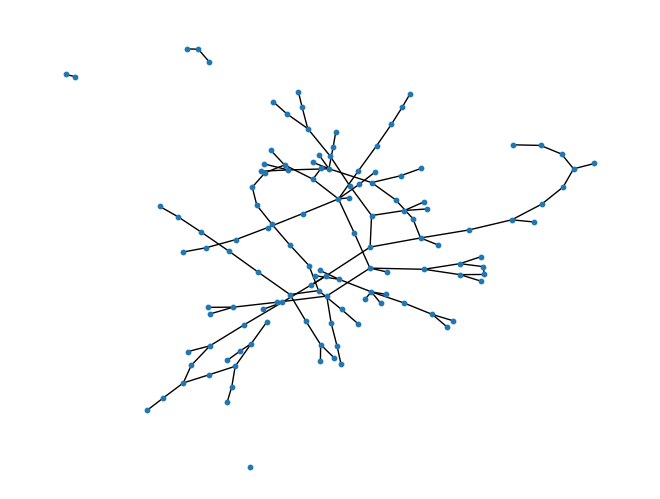

In [9]:
G = nx.from_numpy_array(Aprob.numpy())
nx.draw_spring(G,node_size=10)

In [10]:
A_tree[A_tree<5E-1]=0

In [11]:
from torch.distributions.beta import Beta

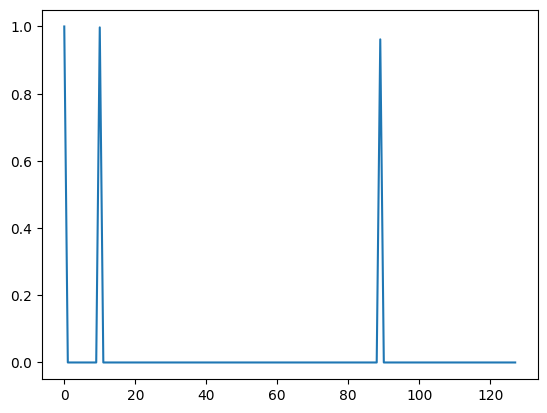

In [12]:
plt.plot(A_tree[0])

In [13]:
A_tree.sum()

np.float64(368.4400453199409)